In [1]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [21]:
import kagglehub

file_path = kagglehub.dataset_download("irustandi/yelp-review-polarity")
print("Downloaded to:", file_path)

os.environ["DATASET_PATH"] = file_path
!mv $DATASET_PATH ./data


100%|██████████| 323M/323M [00:09<00:00, 34.4MB/s] 

Extracting files...


Downloaded to: /Users/mnozkiewicz/.cache/kagglehub/datasets/irustandi/yelp-review-polarity/versions/1


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split

dataset_path = "data/yelp_review_polarity_csv"

df_train = pd.read_csv(f"{dataset_path}/train.csv", header=None, names=["label", "text"])
df_test = pd.read_csv(f"{dataset_path}/test.csv", header=None, names=["label", "text"])
df_train, df_val = train_test_split(df_train, test_size=0.3)

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class GPTBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, padding_mask=None):
        attn_out, _ = self.attn(
            x, x, x,
            key_padding_mask=padding_mask
        )

        x = x + attn_out
        x = x + self.mlp(self.ln1(x))
        return x


class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model=64, n_heads=4, d_ff=256, n_layers=2, num_labels=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed(input_ids)

        padding_mask = (attention_mask == 0) if attention_mask is not None else None
        
        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        repr = x.mean(axis=-2)
        return self.fc(repr)

In [60]:
from torch.utils.data import DataLoader
from dataset import TextDataset
from transformers import DataCollatorWithPadding
import torch

collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(TextDataset(df_train, tokenizer), batch_size=128, collate_fn=collator)
val_loader = DataLoader(TextDataset(df_val, tokenizer), batch_size=128, collate_fn=collator)
test_loader = DataLoader(TextDataset(df_test, tokenizer), batch_size=128, collate_fn=collator)


gpt = TinyGPT(vocab_size=tokenizer.vocab_size)
batch = next(iter(train_loader))
out = gpt(batch["input_ids"], batch["attention_mask"])

sum(p.numel() for p in gpt.parameters()), out.shape

(2053569, torch.Size([128, 1]))

In [49]:
def choose_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [52]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

epochs = 5
grad_clip = 10.0
device = torch.device(choose_device())
print(f"Training on device: {device}")

gpt.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(gpt.parameters())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    gpt.train()
    total_loss, correct, total = 0.0, 0, 0

    progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{epochs}")

    for i, batch in progress:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        out = gpt(batch["input_ids"], batch["attention_mask"])

        loss = criterion(out.view(-1), batch["labels"].view(-1).float())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(gpt.parameters(), grad_clip)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.sigmoid(out).view(-1)
        predicted_labels = (preds >= 0.5).long()

        correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
        total += batch["labels"].numel()

        avg_loss = total_loss / (i + 1)
        acc = correct / total

        progress.set_postfix({"loss": f"{avg_loss:.4f}", "acc": f"{acc:.4f}"})

    train_losses.append(avg_loss)
    train_accs.append(acc)

    print(f"Epoch {epoch} TRAIN | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

    gpt.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = gpt(batch["input_ids"], batch["attention_mask"])
            loss = criterion(out.view(-1), batch["labels"].view(-1).float())

            val_loss += loss.item()

            preds = torch.sigmoid(out).view(-1)
            predicted_labels = (preds >= 0.5).long()

            val_correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
            val_total += batch["labels"].numel()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch} VAL   | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Save the model
torch.save(gpt.state_dict(), "slm.pt")

Training on device: mps


Epoch 1/5: 100%|██████████| 3063/3063 [08:58<00:00,  5.69it/s, loss=0.3116, acc=0.8609]


Epoch 1 TRAIN | Loss: 0.3116 | Acc: 0.8609
Epoch 1 VAL   | Loss: 0.2195 | Acc: 0.9105


Epoch 2/5: 100%|██████████| 3063/3063 [09:00<00:00,  5.66it/s, loss=0.1977, acc=0.9204]


Epoch 2 TRAIN | Loss: 0.1977 | Acc: 0.9204
Epoch 2 VAL   | Loss: 0.1912 | Acc: 0.9239


Epoch 3/5: 100%|██████████| 3063/3063 [09:01<00:00,  5.65it/s, loss=0.1720, acc=0.9318]


Epoch 3 TRAIN | Loss: 0.1720 | Acc: 0.9318
Epoch 3 VAL   | Loss: 0.1831 | Acc: 0.9280


Epoch 4/5: 100%|██████████| 3063/3063 [09:04<00:00,  5.62it/s, loss=0.1573, acc=0.9381]


Epoch 4 TRAIN | Loss: 0.1573 | Acc: 0.9381
Epoch 4 VAL   | Loss: 0.1826 | Acc: 0.9285


Epoch 5/5: 100%|██████████| 3063/3063 [09:03<00:00,  5.64it/s, loss=0.1456, acc=0.9433]


Epoch 5 TRAIN | Loss: 0.1456 | Acc: 0.9433
Epoch 5 VAL   | Loss: 0.1916 | Acc: 0.9271


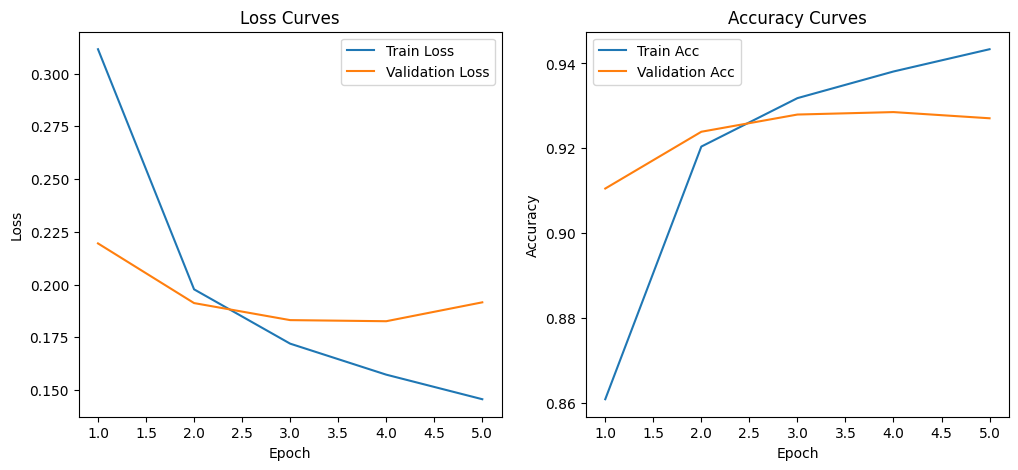

In [53]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()

In [54]:

progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Test evaluation")
gpt.eval()

pred_labels = []
probas = []
real_labels = []

correct = 0
total = 0

with torch.inference_mode():
    for i, batch in progress:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = gpt(batch["input_ids"], batch["attention_mask"])

        preds = torch.sigmoid(out).view(-1)  # convert logits to probabilities
        predicted_labels = (preds >= 0.5).long()

        probas.append(preds)
        pred_labels.append(predicted_labels)
        real_labels.append(batch["labels"].view(-1))

        correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
        total += batch["labels"].numel()
        acc = correct / total

        progress.set_postfix({"acc": f"{acc:.4f}"})

Test evaluation: 100%|██████████| 297/297 [00:30<00:00,  9.72it/s, acc=0.9304]


In [55]:
probas = torch.concatenate(probas)
real_labels = torch.concatenate(real_labels)

In [56]:
probas, real_labels = probas.to("cpu"), real_labels.to("cpu")

In [57]:
from sklearn.metrics import accuracy_score, f1_score

preds = (probas > 0.5).long()
acc = accuracy_score(real_labels, preds)
f1_macro = f1_score(real_labels, preds, average="macro")
f1_weighted = f1_score(real_labels, preds, average="weighted")

print("Accuracy:", acc)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

Accuracy: 0.9303684210526316
F1 macro: 0.9303537247239184
F1 weighted: 0.9303537247239184


In [58]:
sum(p.numel() for p in gpt.parameters())

2053569